<a href="https://colab.research.google.com/github/emmayeh-0211/Team-Topic/blob/main/%E5%B0%88%E9%A1%8C_%E9%AB%98%E9%BA%97%E8%8F%9CRandomForest(3%E5%A4%A9%E9%A0%90%E6%B8%AC_%E4%B8%8D%E5%90%AB%E4%BC%91%E5%B8%82%E8%B3%87%E6%96%99)_%E6%89%B9%E7%99%BC%E5%B8%82%E5%A0%B4%E5%83%B9%E6%A0%BC%E7%89%B9%E5%BE%B5%E5%B7%A5%E7%A8%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 掛載google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


index：日期
input data：批發市場交易量、每日天氣、颱風警報
output answer：批發市場每日交易價格

In [2]:
import pandas as pd
from IPython.display import display
# 資料來自Ai團專_農時_共享資料夾，事先要先將 共享資料夾的捷徑加入自己的雲端硬碟內
w_file_path = '/content/drive/MyDrive/Ai團專_農時_共享資料夾/Dataset_資料集/氣候資料/各縣市氣候資料_0701/dataset.csv'
p_file_path = '/content/drive/MyDrive/Ai團專_農時_共享資料夾/Dataset_資料集/模型訓練之資料集/Cabbage_v2.csv'
weather_df = pd.read_csv(w_file_path) # 氣候資料
weather_df.set_index(["date"], inplace=True)
price_df = pd.read_csv(p_file_path) # 高麗菜的批發交易資料
filter = price_df.Market == '台北一' # 篩選出只有台北一的批發交易資料
price_df = price_df[filter]
price_df.set_index(["Date"], inplace=True)
price_df = price_df.rename(columns={'Avg_price_diff':'price_diff','Volume_diff': 'Vol_diff'})
display(weather_df.tail())
display(price_df.tail())


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (130,132,305,307) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,city_KLU,StnPres_KLU,SeaPres_KLU,StnPresMax_KLU,StnPresMaxTime_KLU,StnPresMin_KLU,StnPresMinTime_KLU,Temperature_KLU,TMax_KLU,TMaxTime_KLU,TMin_KLU,TMinTime_KLU,TdDewPoint_KLU,RH_KLU,RHMin_KLU,RHMinTime_KLU,WS_KLU,WD_KLU,WSGust_KLU,WDGust_KLU,WGustTime_KLU,Precp_KLU,PrecpHour_KLU,PrecpMax10_KLU,PrecpMax10Time_KLU,PrecpMax60_KLU,PrecpMax60Time_KLU,SunShine_KLU,SunShineRate_KLU,GloblRad_KLU,VisbMean_KLU,EvapA_KLU,UVIMax_KLU,UVIMaxTime_KLU,CloudAmount_KLU,city_TPE,StnPres_TPE,SeaPres_TPE,StnPresMax_TPE,StnPresMaxTime_TPE,...,EvapA_HWA,UVIMax_HWA,UVIMaxTime_HWA,CloudAmount_HWA,city_TTT,StnPres_TTT,SeaPres_TTT,StnPresMax_TTT,StnPresMaxTime_TTT,StnPresMin_TTT,StnPresMinTime_TTT,Temperature_TTT,TMax_TTT,TMaxTime_TTT,TMin_TTT,TMinTime_TTT,TdDewPoint_TTT,RH_TTT,RHMin_TTT,RHMinTime_TTT,WS_TTT,WD_TTT,WSGust_TTT,WDGust_TTT,WGustTime_TTT,Precp_TTT,PrecpHour_TTT,PrecpMax10_TTT,PrecpMax10Time_TTT,PrecpMax60_TTT,PrecpMax60Time_TTT,SunShine_TTT,SunShineRate_TTT,GloblRad_TTT,VisbMean_TTT,EvapA_TTT,UVIMax_TTT,UVIMaxTime_TTT,CloudAmount_TTT,WarnMark
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-14,基隆市,997.3,1005.4,999.9,2021-06-14 00:01:00,995.3,2021-06-14 15:33:00,29.6,34.1,2021-06-14 14:15:45,27.3,2021-06-14 03:40:30,26.1,79.8,58.8,2021-06-14 12:36:45,4.7,173.2,13.6,253.0,2021-06-14 10:10:15,0.0,0.0,0.0,NaN,0.0,NaN,8.7,63.7,24.9,31.0,7.4,13.0,2021-06-14 13:00:00,7.5,臺北市,978.9,1164.5,981.5,2021-06-14 03:00:42,...,5.2,13.0,2021-06-14 12:00:00,4.1,臺東縣,966.7,1005.6,969.3,2021-06-14 00:01:25,964.9,2021-06-14 16:40:08,27.2,31.5,2021-06-14 12:35:50,23.8,2021-06-14 04:34:13,25.7,83.9,62.6,2021-06-14 11:24:30,1.6,139.8,7.4,172.0,2021-06-14 13:48:07,0.0,0.0,0.0,NaN,0.0,NaN,10.3,75.8,26.8,23.5,5.8,13.3,2021-06-14 12:40:00,4.5,0
2021-06-15,基隆市,994.7,1002.9,995.9,2021-06-15 00:01:00,993.5,2021-06-15 12:51:00,30.2,33.5,2021-06-15 13:34:45,27.6,2021-06-15 08:42:00,26.0,76.2,62.8,2021-06-15 11:08:00,6.1,231.2,16.5,253.0,2021-06-15 06:39:15,0.0,0.0,0.0,NaN,0.0,NaN,10.9,79.5,27.3,30.6,7.9,13.0,2021-06-15 12:00:00,7.2,臺北市,976.6,1156.6,977.9,2021-06-15 08:28:14,...,6.7,13.0,2021-06-15 13:00:00,4.1,臺東縣,964.6,1003.2,966.3,2021-06-15 12:02:27,963.3,2021-06-15 10:16:10,27.5,32.1,2021-06-15 11:59:22,24.2,2021-06-15 08:52:37,25.4,79.9,59.2,2021-06-15 10:56:33,2.0,148.6,9.4,166.6,2021-06-15 11:59:30,0.0,0.0,0.0,NaN,0.0,NaN,10.6,78.2,26.0,25.3,6.2,12.7,2021-06-15 12:00:00,5.2,0
2021-06-16,基隆市,995.4,1003.5,997.0,2021-06-16 21:56:30,993.4,2021-06-16 02:18:00,31.0,34.4,2021-06-16 15:19:15,27.7,2021-06-16 02:22:45,25.1,68.8,53.5,2021-06-16 15:40:00,8.7,248.8,20.4,260.2,2021-06-16 13:01:15,0.0,0.0,0.0,NaN,0.0,NaN,11.5,84.2,28.6,29.6,10.3,14.0,2021-06-16 12:00:00,2.8,臺北市,977.7,1161.4,979.4,2021-06-16 18:40:42,...,7.7,13.0,2021-06-16 12:00:00,1.9,臺東縣,965.4,1004.2,967.5,2021-06-16 21:56:45,963.5,2021-06-16 05:06:48,28.3,33.2,2021-06-16 12:44:23,24.1,2021-06-16 03:53:27,24.4,72.7,51.6,2021-06-16 13:24:10,2.3,166.5,10.4,194.7,2021-06-16 12:31:57,0.0,0.0,0.0,NaN,0.0,NaN,10.8,79.8,27.8,24.1,7.4,13.0,2021-06-16 12:20:00,4.4,0
2021-06-17,基隆市,996.9,1005.0,998.2,2021-06-17 08:58:15,995.5,2021-06-17 09:14:45,31.1,35.2,2021-06-17 13:44:00,28.0,2021-06-17 05:22:45,25.3,68.8,54.8,2021-06-17 14:04:00,7.9,233.2,18.1,243.2,2021-06-17 06:48:15,0.0,0.0,0.0,NaN,0.0,NaN,11.1,81.3,26.2,23.9,8.6,13.0,2021-06-17 12:00:00,5.8,臺北市,979.0,1166.5,980.5,2021-06-17 08:18:46,...,6.1,13.0,2021-06-17 12:00:00,1.5,臺東縣,966.8,1005.4,968.2,2021-06-17 20:23:43,965.5,2021-06-17 14:22:05,28.4,33.0,2021-06-17 12:45:47,24.9,2021-06-17 10:27:33,24.5,72.5,52.4,2021-06-17 12:09:22,2.0,164.5,9.0,151.5,2021-06-17 14:03:52,0.0,0.0,0.0,NaN,0.0,NaN,10.2,75.2,27.2,25.0,7.2,13.0,2021-06-17 12:00:00,2.5,0
2021-06-18,基隆市,995.5,1003.6,997.1,2021-06-18 03:47:30,993.5,2021-06-18 15:39:30,31.3,35.4,2021-06-18 13:46:15,28.4,2021-06-18 03:33:15,25.4,68.0,50.5,2021-06-18 13:44:45,8.0,232.5,18.7,239.8,2021-06-18 07:33:30,0.0,0.0,0.0,NaN,0.0,NaN,10.3,75.5,26.6,25.8,9.2,14.0,2021-06-18 12:00:0

,Market,Product,Up_price,Mid_price,Low_price,Avg_price,price_diff,Volume,Vol_diff,Month,Week_day,Year,Rest_day
Date,,,,,,,,,,,,,
2021-06-15,台北一,LA1 甘藍 初秋,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,2,2021,1
2021-06-16,台北一,LA1 甘藍 初秋,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,3,2021,1
2021-06-17,台北一,LA1 甘藍 初秋,21.8,15.0,8.5,15.1,-28.10,96289.0,-25.18,6,4,2021,0
2021-06-18,台北一,LA1 甘藍 初秋,21.9,15.2,8.1,15.1,0.00,148701.0,54.43,6,5,2021,0
2021-06-19,台北一,LA1 甘藍 初秋,21.1,15.6,9.4,15.5,2.65,153571.0,3.28,6,6,2021,0


先處理市場批發交易資料：Date、Market、product、Up_price、Mid_price、Low_price、	Avg_price、Volume、Month、Week_day、Year、Rest_day。


---
* 抓出不含休市資料的表格（使用loc不用drop）
* 加入前7天的市場交易資訊（不包含休市了，因此若中間日期有休市日會自動跳過）
* 加入累積7天平均交易資訊
* 加入要預測日的均價（3天後的均價）



In [3]:
# 將市場資料中的
filter = price_df.Rest_day == 0 # 休市日標記為0
indexNames = price_df[filter].index # 符合filter的index們
newprice_df = price_df.loc[indexNames,:] # 使用新的df
newprice_df.Rest_day.value_counts() # 休市日部分只剩下標注為0的資料了
original_pridce_df = newprice_df # 這邊保留原始的檔案

0    6502
Name: Rest_day, dtype: int64

In [4]:
# 加入前6天的交易資訊
for day in range(1, 7):
  columns = ['Up_price', 'Mid_price', 'Low_price', 'Avg_price', 'Volume', 'price_diff', 'Vol_diff']
  temp_df = newprice_df.loc[:, columns]
  shifted_df=temp_df.shift(periods=day)
  shifted_df = shifted_df.add_suffix('_' + str(day) + 'days_ago')
  newprice_df = pd.merge(newprice_df, shifted_df, how='outer', left_index=True, right_index=True)
newprice_df

,Market,Product,Up_price,Mid_price,Low_price,Avg_price,price_diff,Volume,Vol_diff,Month,Week_day,Year,Rest_day,Up_price_1days_ago,Mid_price_1days_ago,Low_price_1days_ago,Avg_price_1days_ago,Volume_1days_ago,price_diff_1days_ago,Vol_diff_1days_ago,Up_price_2days_ago,Mid_price_2days_ago,Low_price_2days_ago,Avg_price_2days_ago,Volume_2days_ago,price_diff_2days_ago,Vol_diff_2days_ago,Up_price_3days_ago,Mid_price_3days_ago,Low_price_3days_ago,Avg_price_3days_ago,Volume_3days_ago,price_diff_3days_ago,Vol_diff_3days_ago,Up_price_4days_ago,Mid_price_4days_ago,Low_price_4days_ago,Avg_price_4days_ago,Volume_4days_ago,price_diff_4days_ago,Vol_diff_4days_ago,Up_price_5days_ago,Mid_price_5days_ago,Low_price_5days_ago,Avg_price_5days_ago,Volume_5days_ago,price_diff_5days_ago,Vol_diff_5days_ago,Up_price_6days_ago,Mid_price_6days_ago,Low_price_6days_ago,Avg_price_6days_ago,Volume_6days_ago,price_diff_6days_ago,Vol_diff_6days_ago
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-02,台北一,LA1 甘藍 初秋,11.0,8.0,5.0,8.9,NaN,192029.0,NaN,1,7,2000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,台北一,LA1 甘藍 初秋,9.0,7.0,4.0,7.2,-19.10,174270.0,-9.25,1,1,2000,0,11.0,8.0,5.0,8.9,192029.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,台北一,LA1 甘藍 初秋,8.0,6.0,3.0,6.7,-6.94,125426.0,-28.03,1,2,2000,0,9.0,7.0,4.0,7.2,174270.0,-19.10,-9.25,11.0,8.0,5.0,8.9,192029.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,台北一,LA1 甘藍 初秋,10.0,7.0,4.0,7.1,5.97,119318.0,-4.87,1,3,2000,0,8.0,6.0,3.0,6.7,125426.0,-6.94,-28.03,9.0,7.0,4.0,7.2,174270.0,-19.10,-9.25,11.0,8.0,5.0,8.9,192029.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,台北一,LA1 甘藍 初秋,9.0,7.0,5.0,6.8,-4.23,118178.0,-0.96,1,4,2000,0,10.0,7.0,4.0,7.1,119318.0,5.97,-4.87,8.0,6.0,3.0,6.7,125426.0,-6.94,-28.03,9.0,7.0,4.0,7.2,174270.0,-19.10,-9.25,11.0,8.0,5.0,8.9,192029.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-13,台北一,LA1 甘藍 初秋,23.0,15.6,6.2,15.2,2.70,174973.0,-9.22,6,7,2021,0,22.2,14.7,7.7,14.8,192738.0,-21.69,61.91,24.5,19.4,11.8,18.9,119038.0,7.39,8.55,22.8,18.1,11.0,17.6,109657.0,6.02,-20.58,22.7,16.5,11.0,16.6,138080.0,10.67,-32.06,22.0,15.2,7.2,15.0,203231.0,-18.03,17.19,24.1,18.7,11.2,18.3,173418.0,-2.14,-3.40
2021-06-14,台北一,LA1 甘藍 初秋,27.4,21.4,13.6,21.0,38.16,128693.0,-26.45,6,1,2021,0,23.0,15.6,6.2,15.2,174973.0,2.70,-9.22,22.2,14.7,7.7,14.8,192738.0,-21.69,61.91,24.5,19.4,11.8,18.9,119038.0,7.39,8.55,22.8,18.1,11.0,17.6,109657.0,6.02,-20.58,22.7,16.5,11.0,16.6,138080.0,10.67,-32.06,22.0,15.2,7.2,15.0,203231.0,-18.03,17.19
2021-06-17,台北一,LA1 甘藍 初秋,21.8,15.0,8.5,15.1,-28.10,96289.0,-25.18,6,4,2021,0,27.4,21.4,13.6,21.0,128693.0,38.16,-26.45,23.0,15.6,6.2,15.2,174973.0,2.70,-9.22,22.2,14.7,7.7,14.8,192738.0,-21.69,61.91,24.5,19.4,11.8,18.9,119038.0,7.39,8.55,22.8,18.1,11.0,17.6,109657.0,6.02,-20.58,22.7,16.5,11.0,16.6,138080.0,10.67,-32.06


In [5]:
newprice_df # 有7天的所有資料
new_cal_df = pd.DataFrame() # 下面資料處理先不能存回原本的表格，先存到新創的表格
new_cal_df

""


In [6]:
# 加入過去一周價格資料的平均
# 方法二，把上面找到的資料加起來做平均
columns = ['Up_price', 'Mid_price', 'Low_price', 'Avg_price', 'Volume', 'price_diff', 'Vol_diff']
for c in columns:
  c_list = list()
  for w in newprice_df.columns:
    if c in w:
      c_list.append(w)
  temp_df = newprice_df.loc[:, c_list]
  # display(temp_df)
  new_cal_df[c + '_mean'] = temp_df.mean(axis=1)
# new_cal_df.tail()

In [7]:
# 加入過去一周價格資料的總和
# 方法二，把上面找到的資料加起來做總和
columns = ['Up_price', 'Mid_price', 'Low_price', 'Avg_price', 'Volume', 'price_diff', 'Vol_diff']
for c in columns:
  c_list = list()
  for w in newprice_df.columns:
    if c in w:
      c_list.append(w)
  temp_df = newprice_df.loc[:, c_list]
  # display(temp_df)
  new_cal_df[c + '_sum'] = temp_df.sum(axis=1)


In [8]:
# 加入過去一周價格資料的中位數
# 方法二，把上面找到的資料加起來取中位數
columns = ['Up_price', 'Mid_price', 'Low_price', 'Avg_price', 'Volume', 'price_diff', 'Vol_diff']
for c in columns:
  c_list = list()
  for w in newprice_df.columns:
    if c in w:
      c_list.append(w)
  temp_df = newprice_df.loc[:, c_list]
  # display(temp_df)
  new_cal_df[c + '_median'] = temp_df.median(axis=1)


In [9]:
# 加入過去一周價格資料的最大值
# 方法二，把上面找到的資料加起來最大值
columns = ['Up_price', 'Mid_price', 'Low_price', 'Avg_price', 'Volume', 'price_diff', 'Vol_diff']
for c in columns:
  c_list = list()
  for w in newprice_df.columns:
    if c in w:
      c_list.append(w)
  temp_df = newprice_df.loc[:, c_list]
  # display(temp_df)
  new_cal_df[c + '_max'] = temp_df.max(axis=1)


In [10]:
# 加入過去一周價格資料的最小值
# 方法二，把上面找到的資料中的小值
columns = ['Up_price', 'Mid_price', 'Low_price', 'Avg_price', 'Volume', 'price_diff', 'Vol_diff']
for c in columns:
  c_list = list()
  for w in newprice_df.columns:
    if c in w:
      c_list.append(w)
  temp_df = newprice_df.loc[:, c_list]
  new_cal_df[c + '_min'] = temp_df.min(axis=1)


In [11]:
# 加入過去一周價格資料的標準差
# 方法二，把上面找到的資料標準差
columns = ['Up_price', 'Mid_price', 'Low_price', 'Avg_price', 'Volume', 'price_diff', 'Vol_diff']
for c in columns:
  c_list = list()
  for w in newprice_df.columns:
    if c in w:
      c_list.append(w)
  temp_df = newprice_df.loc[:, c_list]
  new_cal_df[c + '_std'] = temp_df.std(axis=1)


In [12]:
# # 加入過去一周價格資料的log值？ but 負數無法取log
# # 方法二，把所有的資料取log放進去？
# import numpy as np 
# columns = ['Up_price', 'Mid_price', 'Low_price', 'Avg_price', 'Volume', 'price_diff', 'Vol_diff']
# for c in columns:
#   c_list = list()
#   for w in newprice_df.columns:
#     if c in w:
#       c_list.append(w)
#   temp_df = newprice_df.loc[:, c_list]
#   # display(temp_df)
#   temp_df = np.log(temp_df)
#   temp_df = temp_df.add_suffix('_log')
#   display(temp_df)
#   new_cal_df = pd.merge(new_cal_df, temp_df, how='inner', left_index=True, right_index=True) 
# # for c in new_cal_df.columns:
# #   if 'sum' in c:
# #     data = np.log(new_cal_df[c])
# #     new_cal_df[c + 'log'] = data

In [13]:
# 將上面處理的數據資料，加回original的表格內
newprice_df = pd.merge(original_pridce_df, new_cal_df, how='inner', left_index=True, right_index=True)

In [14]:
# 要預測的答案為7天後的價格，因此把7天後的價格加入
shifted_df=newprice_df.Avg_price.shift(periods=-7)
newprice_df['ans_price'] = shifted_df
newprice_df.loc[:,['Avg_price', 'ans_price']].tail(10)

,Avg_price,ans_price
Date,,
2021-06-08,15.0,15.1
2021-06-09,16.6,15.1
2021-06-10,17.6,15.5
2021-06-11,18.9,NaN
2021-06-12,14.8,NaN
2021-06-13,15.2,NaN
2021-06-14,21.0,NaN
2021-06-17,15.1,NaN
2021-06-18,15.1,NaN


In [15]:
# # 天氣欄位太多，因此只保留 氣溫、最高溫、最低溫、風速、最大風速、雨量 這6個因素
# # 縣市只挑選香蕉主要產地：高雄、屏東、南投、台南、台中、彰化、台東 7個縣市
# factors = ['Temperature', 'T_Max', 'T_Min', 'WS_', 'WSGust', 'Precp_']
# citys = ['KHH', 'IUH', 'NTO', 'TXG', 'CWH', 'TNN', 'TTT']
# keep = ['WarnMark']
# for c in citys:
#   for w in weather_df:
#     if c in w:
#       for f in factors:
#         if f in w:
#           keep.append(w)
# weather_df = weather_df.loc[:, keep]
# weather_df.tail()

In [16]:
# # 天氣資料前處理
# # 以三個月為一期
# # 氣溫 過去90天平均溫度 mean(O)
# # 最高溫 過去90天內最高溫 max
# # 最低溫 過去90天內最低溫 min
# # 雨量 過去90天累積雨量 sum
# # factors = ['Temperature', 'T_Max', 'T_Min', 'WS_', 'WSGust', 'Precp_']
# c_list=list()
# name_list=list()
# for num, name in enumerate(weather_df.columns):
#   if 'Temperature' in name:
#     c_list.append(num)
#     name_list.append(name)

# white_df = pd.DataFrame(index=weather_df.index,columns=name_list)
# white_df = white_df.add_suffix('_mean_of_90days')
# for start in range(len(weather_df.index)):
#   d = weather_df.iloc[start:start+89,c_list].mean(axis=0)
#   d = d.add_suffix('_mean_of_90days')
#   white_df.iloc[start]=d
# weather_df = pd.merge(weather_df, white_df, how='outer', left_index=True, right_index=True) # 將資料合併回weather_df內

In [17]:
# # 天氣資料前處理
# # 以三個月為一期
# # 氣溫 過去90天平均溫度 mean
# # 最高溫 過去90天內最高溫 max(O)
# # 最低溫 過去90天內最低溫 min
# # 雨量 過去90天累積雨量 sum
# # factors = ['Temperature', 'T_Max', 'T_Min', 'WS_', 'WSGust', 'Precp_']
# c_list=list()
# name_list=list()
# for num, name in enumerate(weather_df.columns):
#   if 'T_Max' in name:
#     c_list.append(num)
#     name_list.append(name)

# white_df = pd.DataFrame(index=weather_df.index,columns=name_list)
# white_df = white_df.add_suffix('_max_of_90days')
# for start in range(len(weather_df.index)):
#   d = weather_df.iloc[start:start+89,c_list].max(axis=0)
#   d = d.add_suffix('_max_of_90days')
#   white_df.iloc[start]=d
# weather_df = pd.merge(weather_df, white_df, how='outer', left_index=True, right_index=True) # 將資料合併回weather_df內

In [18]:
# # 天氣資料前處理
# # 以三個月為一期
# # 氣溫 過去90天平均溫度 mean
# # 最高溫 過去90天內最高溫 max
# # 最低溫 過去90天內最低溫 min(O)
# # 雨量 過去90天累積雨量 sum
# # factors = ['Temperature', 'T_Max', 'T_Min', 'WS_', 'WSGust', 'Precp_']
# c_list=list()
# name_list=list()
# for num, name in enumerate(weather_df.columns):
#   if 'T_Min' in name:
#     c_list.append(num)
#     name_list.append(name)

# white_df = pd.DataFrame(index=weather_df.index,columns=name_list)
# white_df = white_df.add_suffix('_min_of_90days')
# for start in range(len(weather_df.index)):
#   d = weather_df.iloc[start:start+89,c_list].min(axis=0)
#   d = d.add_suffix('_min_of_90days')
#   white_df.iloc[start]=d
# weather_df = pd.merge(weather_df, white_df, how='outer', left_index=True, right_index=True) # 將資料合併回weather_df內

In [19]:
# # 天氣資料前處理
# # 以三個月為一期
# # 氣溫 過去90天平均溫度 mean
# # 最高溫 過去90天內最高溫 max
# # 最低溫 過去90天內最低溫 min
# # 雨量 過去90天累積雨量 sum(O)
# # factors = ['Temperature', 'T_Max', 'T_Min', 'WS_', 'WSGust', 'Precp_']
# c_list=list()
# name_list=list()
# for num, name in enumerate(weather_df.columns):
#   if 'Precp_' in name:
#     c_list.append(num)
#     name_list.append(name)

# white_df = pd.DataFrame(index=weather_df.index,columns=name_list)
# white_df = white_df.add_suffix('_sum_of_90days')
# for start in range(len(weather_df.index)):
#   d = weather_df.iloc[start:start+89,c_list].sum(axis=0)
#   d = d.add_suffix('_sum_of_90days')
#   white_df.iloc[start]=d
# weather_df = pd.merge(weather_df, white_df, how='outer', left_index=True, right_index=True) # 將資料合併回weather_df內

In [20]:
# display(weather_df.head())
# display(weather_df.tail())

In [21]:
# # 合併 天氣因素表格&批發市場價格表格
# # how的部分改為inner，因為價格部分不是每天都有，變成以兩個表格都有的資料再做合併
# new_df = pd.merge(weather_df, newprice_df, how='inner', left_index=True, right_index=True) 
# display(new_df.head())
# display(new_df.tail())

In [22]:
new_df = newprice_df

In [23]:
# # 雙Y軸折線圖
# import matplotlib.pyplot as plt
# plt.figure(figsize=(14,5))
# fig, ax1 = plt.subplots()
# plt.title('avg_price v.s volumn')
# plt.xlabel('date')
# ax2 = ax1.twinx()

# ax1.set_ylabel('avg_price', color='tab:blue')
# ax1.plot(new_df.index[:50], new_df.Avg_price[:50], color='tab:blue', alpha=0.75)
# ax1.tick_params(axis='y', labelcolor='tab:blue')

# ax2.set_ylabel('Avg_price_diff', color='black')
# ax2.plot(new_df.index[:50], new_df.Avg_price_diff[:50], color='black', alpha=1)
# ax2.tick_params(axis='y', labelcolor='black')

# fig.tight_layout()
# plt.show()

In [24]:
# 尋找空值
na = new_df.isna().sum()
na[ na > 0].sort_values(ascending=False)

ans_price               7
Vol_diff_6days_ago      7
price_diff_6days_ago    7
price_diff_5days_ago    6
Vol_diff_5days_ago      6
Up_price_6days_ago      6
Mid_price_6days_ago     6
Low_price_6days_ago     6
Avg_price_6days_ago     6
Volume_6days_ago        6
price_diff_4days_ago    5
Up_price_5days_ago      5
Mid_price_5days_ago     5
Low_price_5days_ago     5
Avg_price_5days_ago     5
Volume_5days_ago        5
Vol_diff_4days_ago      5
price_diff_3days_ago    4
Volume_4days_ago        4
Vol_diff_3days_ago      4
Up_price_4days_ago      4
Mid_price_4days_ago     4
Low_price_4days_ago     4
Avg_price_4days_ago     4
Vol_diff_2days_ago      3
Up_price_3days_ago      3
Mid_price_3days_ago     3
Low_price_3days_ago     3
Avg_price_3days_ago     3
Volume_3days_ago        3
price_diff_2days_ago    3
Volume_2days_ago        2
Vol_diff_std            2
Low_price_2days_ago     2
Mid_price_2days_ago     2
Up_price_2days_ago      2
Vol_diff_1days_ago      2
price_diff_1days_ago    2
Avg_price_2d

In [25]:
# 另外因為只有針對單一市場跟作物，因此不需要 Market 跟 Product 兩個欄位了，使用drop方式移除，然後也不需要rest day了
new_df = new_df.drop(columns=['Market', 'Product', 'Rest_day'], axis=1)
display(new_df.head())
display(new_df.tail())

,Up_price,Mid_price,Low_price,Avg_price,price_diff,Volume,Vol_diff,Month,Week_day,Year,Up_price_1days_ago,Mid_price_1days_ago,Low_price_1days_ago,Avg_price_1days_ago,Volume_1days_ago,price_diff_1days_ago,Vol_diff_1days_ago,Up_price_2days_ago,Mid_price_2days_ago,Low_price_2days_ago,Avg_price_2days_ago,Volume_2days_ago,price_diff_2days_ago,Vol_diff_2days_ago,Up_price_3days_ago,Mid_price_3days_ago,Low_price_3days_ago,Avg_price_3days_ago,Volume_3days_ago,price_diff_3days_ago,Vol_diff_3days_ago,Up_price_4days_ago,Mid_price_4days_ago,Low_price_4days_ago,Avg_price_4days_ago,Volume_4days_ago,price_diff_4days_ago,Vol_diff_4days_ago,Up_price_5days_ago,Mid_price_5days_ago,...,Avg_price_mean,Volume_mean,price_diff_mean,Vol_diff_mean,Up_price_sum,Mid_price_sum,Low_price_sum,Avg_price_sum,Volume_sum,price_diff_sum,Vol_diff_sum,Up_price_median,Mid_price_median,Low_price_median,Avg_price_median,Volume_median,price_diff_median,Vol_diff_median,Up_price_max,Mid_price_max,Low_price_max,Avg_price_max,Volume_max,price_diff_max,Vol_diff_max,Up_price_min,Mid_price_min,Low_price_min,Avg_price_min,Volume_min,price_diff_min,Vol_diff_min,Up_price_std,Mid_price_std,Low_price_std,Avg_price_std,Volume_std,price_diff_std,Vol_diff_std,ans_price
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-02,11.0,8.0,5.0,8.9,NaN,192029.0,NaN,1,7,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.900,192029.000000,NaN,NaN,11.0,8.0,5.0,8.9,192029.0,0.00,0.00,11.0,8.0,5.0,8.90,192029.0,NaN,NaN,11.0,8.0,5.0,8.9,192029.0,NaN,NaN,11.0,8.0,5.0,8.9,192029.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.4
2000-01-03,9.0,7.0,4.0,7.2,-19.10,174270.0,-9.25,1,1,2000,11.0,8.0,5.0,8.9,192029.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.050,183149.500000,-19.100,-9.2500,20.0,15.0,9.0,16.1,366299.0,-19.10,-9.25,10.0,7.5,4.5,8.05,183149.5,-19.100,-9.25,11.0,8.0,5.0,8.9,192029.0,-19.10,-9.25,9.0,7.0,4.0,7.2,174270.0,-19.1,-9.25,1.414214,0.707107,0.707107,1.202082,12557.509327,NaN,NaN,5.5
2000-01-04,8.0,6.0,3.0,6.7,-6.94,125426.0,-28.03,1,2,2000,9.0,7.0,4.0,7.2,174270.0,-19.10,-9.25,11.0,8.0,5.0,8.9,192029.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.600,163908.333333,-13.020,-18.6400,28.0,21.0,12.0,22.8,491725.0,-26.04,-37.28,9.0,7.0,4.0,7.20,174270.0,-13.020,-18.64,11.0,8.0,5.0,8.9,192029.0,-6.94,-9.25,8.0,6.0,3.0,6.7,125426.0,-19.1,-28.03,1.527525,1.000000,1.000000,1.153256,34489.317249,8.598418,13.279465,4.8
2000-01-05,10.0,7.0,4.0,7.1,5.97,119318.0,-4.87,1,3,2000,8.0,6.0,3.0,6.7,125426.0,-6.94,-28.03,9.0,7.0,4.0,7.2,174270.0,-19.10,-9.25,11.0,8.0,5.0,8.9,192029.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.475,152760.750000,-6.690,-14.0500,38.0,28.0,16.0,29.9,611043.0,-20.07,-42.15,9.5,7.0,4.0,7.15,149848.0,-6.940,-9.25,11.0,8.0,5.0,8.9,192029.0,5.97,-4.87,8.0,6.0,3.0,6.7,119318.0,-19.1,-28.03,1.290994,0.816497,0.816497,0.974252,35917.727187,12.536870,12.303512,6.0
2000-01-06,9.0,7.0,5.0,6.8,-4.23,118178.0,-0.96,1,4,2000,10.0,7.0,4.0,7.1,119318.0,5.97,-4.87,8.0,6.0,3.0,6.7,125426.0,-6.94,-28.03,9.0,7.0,4.0,7.2,174270.0,-19.1,-9.25,11.0,8.0,5.0,8.9,192029.0,NaN,NaN,NaN,NaN,...,7.340,145844.200000,-6.075,-10.7775,47.0,35.0,21.0,36.7,729221.0,-24.30,-43.11,9.0,7.0,4.0,7.10,125426.0,-5.585,-7.06,11.0,8.0,5.0,8.9,192029.0,5.97,-0.96,8.0,6.0,3.0,6.7,118178.0,-19.1,-28.03,1.140175,0.707107,0.836660,0.896103,34738.388912,10.309945,11.989772,5.5


,Up_price,Mid_price,Low_price,Avg_price,price_diff,Volume,Vol_diff,Month,Week_day,Year,Up_price_1days_ago,Mid_price_1days_ago,Low_price_1days_ago,Avg_price_1days_ago,Volume_1days_ago,price_diff_1days_ago,Vol_diff_1days_ago,Up_price_2days_ago,Mid_price_2days_ago,Low_price_2days_ago,Avg_price_2days_ago,Volume_2days_ago,price_diff_2days_ago,Vol_diff_2days_ago,Up_price_3days_ago,Mid_price_3days_ago,Low_price_3days_ago,Avg_price_3days_ago,Volume_3days_ago,price_diff_3days_ago,Vol_diff_3days_ago,Up_price_4days_ago,Mid_price_4days_ago,Low_price_4days_ago,Avg_price_4days_ago,Volume_4days_ago,price_diff_4days_ago,Vol_diff_4days_ago,Up_price_5days_ago,Mid_price_5days_ago,...,Avg_price_mean,Volume_mean,price_diff_mean,Vol_diff_mean,Up_price_sum,Mid_price_sum,Low_price_sum,Avg_price_sum,Volume_sum,price_diff_sum,Vol_diff_sum,Up_price_median,Mid_price_median,Low_price_median,Avg_price_median,Volume_median,price_diff_median,Vol_diff_median,Up_price_max,Mid_price_max,Low_price_max,Avg_price_max,Volume_max,price_diff_max,Vol_diff_max,Up_price_min,Mid_price_min,Low_price_min,Avg_price_min,Volume_min,price_diff_min,Vol_diff_min,Up_price_std,Mid_price_std,Low_price_std,Avg_price_std,Volume_std,price_diff_std,Vol_diff_std,ans_price
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-13,23.0,15.6,6.2,15.2,2.70,174973.0,-9.22,6,7,2021,22.2,14.7,7.7,14.8,192738.0,-21.69,61.91,24.5,19.4,11.8,18.9,119038.0,7.39,8.55,22.8,18.1,11.0,17.6,109657.0,6.02,-20.58,22.7,16.5,11.0,16.6,138080.0,10.67,-32.06,22.0,15.2,...,16.628571,158733.571429,-2.154286,3.198571,161.3,118.2,66.1,116.4,1111135.0,-15.08,22.39,22.8,16.5,11.0,16.6,173418.0,2.70,-3.40,24.5,19.4,11.8,18.9,203231.0,10.67,61.91,22.0,14.7,6.2,14.8,109657.0,-21.69,-32.06,0.932483,1.848809,2.312183,1.679994,36575.246779,12.777724,30.761933,NaN
2021-06-14,27.4,21.4,13.6,21.0,38.16,128693.0,-26.45,6,1,2021,23.0,15.6,6.2,15.2,174973.0,2.70,-9.22,22.2,14.7,7.7,14.8,192738.0,-21.69,61.91,24.5,19.4,11.8,18.9,119038.0,7.39,8.55,22.8,18.1,11.0,17.6,109657.0,6.02,-20.58,22.7,16.5,...,17.014286,152344.285714,3.602857,-0.094286,164.6,120.9,68.5,119.1,1066410.0,25.22,-0.66,22.8,16.5,11.0,16.6,138080.0,6.02,-9.22,27.4,21.4,13.6,21.0,203231.0,38.16,61.91,22.0,14.7,6.2,14.8,109657.0,-21.69,-32.06,1.894227,2.468275,2.752229,2.316915,37477.848452,19.886553,32.755090,NaN
2021-06-17,21.8,15.0,8.5,15.1,-28.10,96289.0,-25.18,6,4,2021,27.4,21.4,13.6,21.0,128693.0,38.16,-26.45,23.0,15.6,6.2,15.2,174973.0,2.70,-9.22,22.2,14.7,7.7,14.8,192738.0,-21.69,61.91,24.5,19.4,11.8,18.9,119038.0,7.39,8.55,22.8,18.1,...,17.028571,137066.857143,2.164286,-6.147143,164.4,120.7,69.8,119.2,959468.0,15.15,-43.03,22.8,16.5,11.0,16.6,128693.0,6.02,-20.58,27.4,21.4,13.6,21.0,192738.0,38.16,61.91,21.8,14.7,6.2,14.8,96289.0,-28.10,-32.06,1.922176,2.497237,2.587608,2.302690,34991.602199,21.967606,32.943038,NaN
2021-06-18,21.9,15.2,8.1,15.1,0.00,148701.0,54.43,6,5,2021,21.8,15.0,8.5,15.1,96289.0,-28.10,-25.18,27.4,21.4,13.6,21.0,128693.0,38.16,-26.45,23.0,15.6,6.2,15.2,174973.0,2.70,-9.22,22.2,14.7,7.7,14.8,192738.0,-21.69,61.91,24.5,19.4,...,16.814286,138584.142857,0.640000,6.208571,163.6,119.4,66.9,117.7,970089.0,4.48,43.46,22.8,15.6,8.5,15.2,128693.0,2.70,-9.22,27.4,21.4,13.6,21.0,192738.0,38.16,61.91,21.8,14.7,6.2,14.8,96289.0,-28.10,-26.45,1.998928,2.607590,2.627329,2.416215,35272.002771,21.646890,37.507623,NaN
2021-06-19,21.1,15.6,9.4,15.5,2.65,153571.0,3.28,6,6,2021,21.9,15.2,8.1,15.1,148701.0,0.00,54.43,21.8,15.0,8.5,15.1,96289.0,-28.10,-25.18,27.4,21.4,13.6,21.0,128693.0,38.16,-26.45,23.0,15.6,6.2,15.2,174973.0,2.70,-9.22,22.2,14.7,...,16.514286,144857.571429,0.158571,9.617143,161.9,116.9,65.3,115.6,1014003.0,1.11,67.32,22.2,15.6,8.5,15.2,148701.0,2.65,3.28,27.4,21.4,13.6,21.0,192738.0,38.16,61.91,21.1,14.7,6.2,14.8,96289.0,-28.10,-26.45,2.175404,2.612151,2.549323,2.432714,33108.458204,21.544529,35.708428,NaN


In [26]:
# 前後有空值，丟棄空值的資料
new_df.dropna(axis=0, how='any', inplace=True)


In [27]:
# 尋找空值，要無空值才是正常
na = new_df.isna().sum()
na[ na > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [28]:
# 先將跨模組的驗證資料切割出來，以2020-06-01以後的資料作為 測試資料
test_df = new_df.loc['2020-06-01':,:] # 測試資料
merge_df = new_df.loc[:'2020-05-31', :] # 模型使用
display(merge_df.tail())
display(test_df.head())

,Up_price,Mid_price,Low_price,Avg_price,price_diff,Volume,Vol_diff,Month,Week_day,Year,Up_price_1days_ago,Mid_price_1days_ago,Low_price_1days_ago,Avg_price_1days_ago,Volume_1days_ago,price_diff_1days_ago,Vol_diff_1days_ago,Up_price_2days_ago,Mid_price_2days_ago,Low_price_2days_ago,Avg_price_2days_ago,Volume_2days_ago,price_diff_2days_ago,Vol_diff_2days_ago,Up_price_3days_ago,Mid_price_3days_ago,Low_price_3days_ago,Avg_price_3days_ago,Volume_3days_ago,price_diff_3days_ago,Vol_diff_3days_ago,Up_price_4days_ago,Mid_price_4days_ago,Low_price_4days_ago,Avg_price_4days_ago,Volume_4days_ago,price_diff_4days_ago,Vol_diff_4days_ago,Up_price_5days_ago,Mid_price_5days_ago,...,Avg_price_mean,Volume_mean,price_diff_mean,Vol_diff_mean,Up_price_sum,Mid_price_sum,Low_price_sum,Avg_price_sum,Volume_sum,price_diff_sum,Vol_diff_sum,Up_price_median,Mid_price_median,Low_price_median,Avg_price_median,Volume_median,price_diff_median,Vol_diff_median,Up_price_max,Mid_price_max,Low_price_max,Avg_price_max,Volume_max,price_diff_max,Vol_diff_max,Up_price_min,Mid_price_min,Low_price_min,Avg_price_min,Volume_min,price_diff_min,Vol_diff_min,Up_price_std,Mid_price_std,Low_price_std,Avg_price_std,Volume_std,price_diff_std,Vol_diff_std,ans_price
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-05-27,25.7,16.3,8.7,16.7,-10.70,172209.0,-2.96,5,3,2020,26.1,18.4,12.4,18.7,177459.0,5.06,20.50,23.1,17.9,12.3,17.8,147265.0,8.54,-0.94,20.2,16.5,12.2,16.4,148661.0,5.13,-3.18,19.5,15.9,10.7,15.6,153547.0,5.41,-1.45,18.3,14.9,...,16.557143,157061.285714,1.992857,-0.338571,151.5,115.9,80.4,115.9,1099429.0,13.95,-2.37,20.2,16.3,12.2,16.4,153547.0,5.13,-1.45,26.1,18.4,13.1,18.7,177459.0,8.54,20.50,18.3,14.9,8.7,14.8,144488.0,-10.7,-22.17,3.305479,1.208108,1.484844,1.330234,12806.772749,7.570790,12.871969,14.8
2020-05-28,22.1,15.9,10.9,16.2,-2.99,139310.0,-19.10,5,4,2020,25.7,16.3,8.7,16.7,172209.0,-10.70,-2.96,26.1,18.4,12.4,18.7,177459.0,5.06,20.50,23.1,17.9,12.3,17.8,147265.0,8.54,-0.94,20.2,16.5,12.2,16.4,148661.0,5.13,-3.18,19.5,15.9,...,16.600000,156321.571429,0.504286,0.100000,155.0,115.8,78.2,116.2,1094251.0,3.53,0.70,22.1,16.3,11.0,16.4,153547.0,5.06,-1.45,26.1,18.4,12.4,18.7,177459.0,8.54,20.50,18.3,14.9,8.7,14.8,139310.0,-10.7,-19.10,3.020959,1.216357,1.308580,1.310216,13767.540084,7.344574,12.028847,15.7
2020-05-29,22.8,18.0,12.1,17.8,9.88,135844.0,-2.49,5,5,2020,22.1,15.9,10.9,16.2,139310.0,-2.99,-19.10,25.7,16.3,8.7,16.7,172209.0,-10.70,-2.96,26.1,18.4,12.4,18.7,177459.0,5.06,20.50,23.1,17.9,12.3,17.8,147265.0,8.54,-0.94,20.2,16.5,...,17.028571,153470.714286,2.904286,-1.374286,159.5,118.9,79.3,119.2,1074295.0,20.33,-9.62,22.8,16.5,12.1,16.7,148661.0,5.13,-2.49,26.1,18.4,12.4,18.7,177459.0,9.88,20.50,19.5,15.9,8.7,15.6,135844.0,-10.7,-19.10,2.500952,1.074598,1.349956,1.096531,15808.426811,7.258565,11.546281,15.1
2020-05-30,26.3,18.2,11.5,18.5,3.93,183403.0,35.01,5,6,2020,22.8,18.0,12.1,17.8,135844.0,9.88,-2.49,22.1,15.9,10.9,16.2,139310.0,-2.99,-19.10,25.7,16.3,8.7,16.7,172209.0,-10.70,-2.96,26.1,18.4,12.4,18.7,177459.0,5.06,20.50,23.1,17.9,...,17.442857,157735.857143,2.692857,3.834286,166.3,121.2,80.1,122.1,1104151.0,18.85,26.84,23.1,17.9,12.1,17.8,148661.0,5.06,-2.49,26.3,18.4,12.4,18.7,183403.0,9.88,35.01,20.2,15.9,8.7,16.2,135844.0,-10.7,-19.10,2.326555,1.038314,1.321435,1.011364,19442.367624,7.194687,17.952742,16.2
2020-05-31,25.1,18.7,12.1,18.7,1.08,206018.0,12.33,5,7,2020,26.3,18.2,11.5,18.5,183403.0,3.93,35.01,22.8,18.0,12.1,17.8,135844.0,9.88,-2.49,22.1,15.9,10.9,16.2,139310.0,-2.99,-19.10,25.7,16.3,8.7,16.7,172209.0,-10.70,-2.96,26.1,18.4,...,17.771429,165929.714286,2.114286,6.050000,171.2,123.4,80.0,124.4,1161508.0,14.80,42.35,25.1,18.0,12.1,17.8,172209.0,3.93,-0.94,26.3,18.7,12.4,18.7,206018.0,9.88,35.01,22.1,15.9,8.7,16.2,135844.0,-10.7,-19.10,1.741510,1.082765,1.312395,0.989468,25970.724465,7.128576,17.899799,20.3


,Up_price,Mid_price,Low_price,Avg_price,price_diff,Volume,Vol_diff,Month,Week_day,Year,Up_price_1days_ago,Mid_price_1days_ago,Low_price_1days_ago,Avg_price_1days_ago,Volume_1days_ago,price_diff_1days_ago,Vol_diff_1days_ago,Up_price_2days_ago,Mid_price_2days_ago,Low_price_2days_ago,Avg_price_2days_ago,Volume_2days_ago,price_diff_2days_ago,Vol_diff_2days_ago,Up_price_3days_ago,Mid_price_3days_ago,Low_price_3days_ago,Avg_price_3days_ago,Volume_3days_ago,price_diff_3days_ago,Vol_diff_3days_ago,Up_price_4days_ago,Mid_price_4days_ago,Low_price_4days_ago,Avg_price_4days_ago,Volume_4days_ago,price_diff_4days_ago,Vol_diff_4days_ago,Up_price_5days_ago,Mid_price_5days_ago,...,Avg_price_mean,Volume_mean,price_diff_mean,Vol_diff_mean,Up_price_sum,Mid_price_sum,Low_price_sum,Avg_price_sum,Volume_sum,price_diff_sum,Vol_diff_sum,Up_price_median,Mid_price_median,Low_price_median,Avg_price_median,Volume_median,price_diff_median,Vol_diff_median,Up_price_max,Mid_price_max,Low_price_max,Avg_price_max,Volume_max,price_diff_max,Vol_diff_max,Up_price_min,Mid_price_min,Low_price_min,Avg_price_min,Volume_min,price_diff_min,Vol_diff_min,Up_price_std,Mid_price_std,Low_price_std,Avg_price_std,Volume_std,price_diff_std,Vol_diff_std,ans_price
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-02,22.7,17.3,12.1,17.4,-6.95,226374.0,9.88,6,2,2020,25.1,18.7,12.1,18.7,206018.0,1.08,12.33,26.3,18.2,11.5,18.5,183403.0,3.93,35.01,22.8,18.0,12.1,17.8,135844.0,9.88,-2.49,22.1,15.9,10.9,16.2,139310.0,-2.99,-19.10,25.7,16.3,...,17.714286,177231.000000,-0.098571,7.595714,170.8,122.8,79.8,124.0,1240617.0,-0.69,53.17,25.1,18.0,12.1,17.8,177459.0,1.08,9.88,26.3,18.7,12.4,18.7,226374.0,9.88,35.01,22.1,15.9,8.7,16.2,135844.0,-10.70,-19.10,1.799074,1.081445,1.292285,0.999047,32807.463277,7.205251,17.661167,20.2
2020-06-03,23.4,16.7,9.4,16.6,-4.60,181927.0,-19.63,6,3,2020,22.7,17.3,12.1,17.4,226374.0,-6.95,9.88,25.1,18.7,12.1,18.7,206018.0,1.08,12.33,26.3,18.2,11.5,18.5,183403.0,3.93,35.01,22.8,18.0,12.1,17.8,135844.0,9.88,-2.49,22.1,15.9,...,17.414286,177869.285714,-1.478571,1.862857,168.1,121.1,76.8,121.9,1245085.0,-10.35,13.04,23.4,17.3,11.5,17.4,181927.0,-2.99,-2.49,26.3,18.7,12.1,18.7,226374.0,9.88,35.01,22.1,15.9,8.7,16.2,135844.0,-10.70,-19.63,1.657738,1.047219,1.398469,0.968553,32856.066034,6.973941,19.218742,17.5
2020-06-04,21.7,14.7,8.2,14.8,-10.84,187080.0,2.83,6,4,2020,23.4,16.7,9.4,16.6,181927.0,-4.60,-19.63,22.7,17.3,12.1,17.4,226374.0,-6.95,9.88,25.1,18.7,12.1,18.7,206018.0,1.08,12.33,26.3,18.2,11.5,18.5,183403.0,3.93,35.01,22.8,18.0,...,17.142857,179993.714286,-1.498571,2.690000,164.1,119.5,76.3,120.0,1259956.0,-10.49,18.83,22.8,17.3,11.5,17.4,183403.0,-2.99,2.83,26.3,18.7,12.1,18.7,226374.0,9.88,35.01,21.7,14.7,8.2,14.8,135844.0,-10.84,-19.63,1.669189,1.412698,1.539480,1.380649,32909.807296,7.004925,19.100814,18.0
2020-06-05,20.9,15.5,11.0,15.7,6.08,153694.0,-17.85,6,5,2020,21.7,14.7,8.2,14.8,187080.0,-10.84,2.83,23.4,16.7,9.4,16.6,181927.0,-4.60,-19.63,22.7,17.3,12.1,17.4,226374.0,-6.95,9.88,25.1,18.7,12.1,18.7,206018.0,1.08,12.33,26.3,18.2,...,17.071429,182048.571429,-0.202857,2.868571,162.9,119.1,76.4,119.5,1274340.0,-1.42,20.08,22.8,17.3,11.5,17.4,183403.0,1.08,2.83,26.3,18.7,12.1,18.7,226374.0,9.88,35.01,20.9,14.7,8.2,14.8,135844.0,-10.84,-19.63,1.878576,1.474707,1.539944,1.448809,30291.048721,7.504134,18.867569,24.9
2020-06-06,20.9,15.1,9.0,15.1,-3.82,192696.0,25.38,6,6,2020,20.9,15.5,11.0,15.7,153694.0,6.08,-17.85,21.7,14.7,8.2,14.8,187080.0,-10.84,2.83,23.4,16.7,9.4,16.6,181927.0,-4.60,-19.63,22.7,17.3,12.1,17.4,226374.0,-6.95,9.88,25.1,18.7,...,16.685714,190170.285714,-2.160000,6.850000,161.0,116.2,73.3,116.8,1331192.0,-15.12,47.95,22.7,16.7,11.0,16.6,187080.0,-3.82,9.88,26.3,18.7,12.1,18.7,226374.0,6.08,35.01,20.9,14.7,8.2,14.8,153694.0,-10.84,-19.63,2.084067,1.556706,1.587151,1.576313,22442.724914,6.089321,20.424653,25.3


In [29]:
# 將資料切割為訓練集&驗證集，時序不能重疊到，hen難懂(攤手)
# 最簡單的方法，用時間來切割 訓練集跟驗證集，即可避免時序重疊 9 / 1 切，驗證集資料約為620筆
import numpy as np

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
  
merge_df = clean_dataset(merge_df)

train_df = merge_df.iloc[:-600]
valid_df = merge_df.iloc[-600:]
display(train_df.tail())
display(valid_df.head())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Up_price,Mid_price,Low_price,Avg_price,price_diff,Volume,Vol_diff,Month,Week_day,Year,Up_price_1days_ago,Mid_price_1days_ago,Low_price_1days_ago,Avg_price_1days_ago,Volume_1days_ago,price_diff_1days_ago,Vol_diff_1days_ago,Up_price_2days_ago,Mid_price_2days_ago,Low_price_2days_ago,Avg_price_2days_ago,Volume_2days_ago,price_diff_2days_ago,Vol_diff_2days_ago,Up_price_3days_ago,Mid_price_3days_ago,Low_price_3days_ago,Avg_price_3days_ago,Volume_3days_ago,price_diff_3days_ago,Vol_diff_3days_ago,Up_price_4days_ago,Mid_price_4days_ago,Low_price_4days_ago,Avg_price_4days_ago,Volume_4days_ago,price_diff_4days_ago,Vol_diff_4days_ago,Up_price_5days_ago,Mid_price_5days_ago,...,Avg_price_mean,Volume_mean,price_diff_mean,Vol_diff_mean,Up_price_sum,Mid_price_sum,Low_price_sum,Avg_price_sum,Volume_sum,price_diff_sum,Vol_diff_sum,Up_price_median,Mid_price_median,Low_price_median,Avg_price_median,Volume_median,price_diff_median,Vol_diff_median,Up_price_max,Mid_price_max,Low_price_max,Avg_price_max,Volume_max,price_diff_max,Vol_diff_max,Up_price_min,Mid_price_min,Low_price_min,Avg_price_min,Volume_min,price_diff_min,Vol_diff_min,Up_price_std,Mid_price_std,Low_price_std,Avg_price_std,Volume_std,price_diff_std,Vol_diff_std,ans_price
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-05-29,20.1,17.2,12.8,16.9,18.18,134375.0,-10.55,5.0,2.0,2018.0,18.2,14.6,9.1,14.3,150228.0,8.33,-6.22,16.9,13.6,8.4,13.2,160184.0,-2.22,8.01,15.6,13.6,10.8,13.5,148302.0,6.30,-1.59,15.4,12.5,10.5,12.7,150697.0,14.41,-4.78,13.9,11.1,...,13.171429,151468.000000,6.594286,2.300000,114.1,92.9,67.5,92.2,1060276.0,46.16,16.10,15.6,13.6,9.1,13.2,150697.0,6.30,-1.59,20.1,17.2,12.8,16.9,160184.0,18.18,31.20,13.9,10.3,7.6,10.5,134375.0,-4.55,-10.55,2.264214,2.293261,1.819210,2.118737,8870.844830,8.176003,13.999633,14.4
2018-05-30,17.0,12.9,8.6,12.9,-23.67,172072.0,28.05,5.0,3.0,2018.0,20.1,17.2,12.8,16.9,134375.0,18.18,-10.55,18.2,14.6,9.1,14.3,150228.0,8.33,-6.22,16.9,13.6,8.4,13.2,160184.0,-2.22,8.01,15.6,13.6,10.8,13.5,148302.0,6.30,-1.59,15.4,12.5,...,13.514286,153446.428571,3.862857,1.850000,117.1,95.5,68.5,94.6,1074125.0,27.04,12.95,16.9,13.6,9.1,13.2,150697.0,6.30,-1.59,20.1,17.2,12.8,16.9,172072.0,18.18,28.05,13.9,11.1,8.3,11.1,134375.0,-23.67,-10.55,2.027901,1.910373,1.664761,1.781786,11716.419118,13.787610,12.925256,13.6
2018-05-31,16.3,12.8,8.7,12.7,-1.55,146569.0,-14.82,5.0,4.0,2018.0,17.0,12.9,8.6,12.9,172072.0,-23.67,28.05,20.1,17.2,12.8,16.9,134375.0,18.18,-10.55,18.2,14.6,9.1,14.3,150228.0,8.33,-6.22,16.9,13.6,8.4,13.2,160184.0,-2.22,8.01,15.6,13.6,...,13.742857,151775.285714,2.825714,-0.271429,119.5,97.2,68.9,96.2,1062427.0,19.78,-1.90,16.9,13.6,9.1,13.2,150228.0,6.30,-4.78,20.1,17.2,12.8,16.9,172072.0,18.18,28.05,15.4,12.5,8.4,12.7,134375.0,-23.67,-14.82,1.634742,1.619083,1.611270,1.500952,11748.467612,13.898121,14.407444,12.4
2018-06-01,19.8,16.2,10.4,15.7,23.62,120151.0,-18.02,6.0,5.0,2018.0,16.3,12.8,8.7,12.7,146569.0,-1.55,-14.82,17.0,12.9,8.6,12.9,172072.0,-23.67,28.05,20.1,17.2,12.8,16.9,134375.0,18.18,-10.55,18.2,14.6,9.1,14.3,150228.0,8.33,-6.22,16.9,13.6,...,14.171429,147411.571429,4.141429,-2.162857,123.9,100.9,68.8,99.2,1031881.0,28.99,-15.14,17.0,13.6,9.1,13.5,148302.0,6.30,-6.22,20.1,17.2,12.8,16.9,172072.0,23.62,28.05,15.6,12.8,8.4,12.7,120151.0,-23.67,-18.02,1.728198,1.693545,1.604903,1.579783,16801.774101,15.518996,15.890714,11.9
2018-06-02,20.3,15.9,10.9,15.8,0.64,137349.0,14.31,6.0,6.0,2018.0,19.8,16.2,10.4,15.7,120151.0,23.62,-18.02,16.3,12.8,8.7,12.7,146569.0,-1.55,-14.82,17.0,12.9,8.6,12.9,172072.0,-23.67,28.05,20.1,17.2,12.8,16.9,134375.0,18.18,-10.55,18.2,14.6,...,14.500000,145846.857143,3.332857,0.108571,128.6,103.2,68.9,101.5,1020928.0,23.33,0.76,18.2,14.6,9.1,14.3,146569.0,0.64,-6.22,20.3,17.2,12.8,16.9,172072.0,23.62,28.05,16.3,12.8,8.4,12.7,120151.0,-23.67,-18.02,1.688899,1.731913,1.615402,1.654287,17210.083492,15.535226,17.078251,10.9


,Up_price,Mid_price,Low_price,Avg_price,price_diff,Volume,Vol_diff,Month,Week_day,Year,Up_price_1days_ago,Mid_price_1days_ago,Low_price_1days_ago,Avg_price_1days_ago,Volume_1days_ago,price_diff_1days_ago,Vol_diff_1days_ago,Up_price_2days_ago,Mid_price_2days_ago,Low_price_2days_ago,Avg_price_2days_ago,Volume_2days_ago,price_diff_2days_ago,Vol_diff_2days_ago,Up_price_3days_ago,Mid_price_3days_ago,Low_price_3days_ago,Avg_price_3days_ago,Volume_3days_ago,price_diff_3days_ago,Vol_diff_3days_ago,Up_price_4days_ago,Mid_price_4days_ago,Low_price_4days_ago,Avg_price_4days_ago,Volume_4days_ago,price_diff_4days_ago,Vol_diff_4days_ago,Up_price_5days_ago,Mid_price_5days_ago,...,Avg_price_mean,Volume_mean,price_diff_mean,Vol_diff_mean,Up_price_sum,Mid_price_sum,Low_price_sum,Avg_price_sum,Volume_sum,price_diff_sum,Vol_diff_sum,Up_price_median,Mid_price_median,Low_price_median,Avg_price_median,Volume_median,price_diff_median,Vol_diff_median,Up_price_max,Mid_price_max,Low_price_max,Avg_price_max,Volume_max,price_diff_max,Vol_diff_max,Up_price_min,Mid_price_min,Low_price_min,Avg_price_min,Volume_min,price_diff_min,Vol_diff_min,Up_price_std,Mid_price_std,Low_price_std,Avg_price_std,Volume_std,price_diff_std,Vol_diff_std,ans_price
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-03,20.3,17.7,13.9,17.5,10.76,145768.0,6.13,6.0,7.0,2018.0,20.3,15.9,10.9,15.8,137349.0,0.64,14.31,19.8,16.2,10.4,15.7,120151.0,23.62,-18.02,16.3,12.8,8.7,12.7,146569.0,-1.55,-14.82,17.0,12.9,8.6,12.9,172072.0,-23.67,28.05,20.1,17.2,...,15.114286,143787.428571,5.187143,-0.160000,132.0,107.3,74.4,105.8,1006512.0,36.31,-1.12,19.8,15.9,10.4,15.7,145768.0,8.33,-6.22,20.3,17.7,13.9,17.5,172072.0,23.62,28.05,16.3,12.8,8.6,12.7,120151.0,-23.67,-18.02,1.684099,1.959349,2.070197,1.874770,16030.625241,15.536619,16.947566,11.9
2018-06-05,19.3,16.4,11.8,16.1,-8.00,180081.0,23.54,6.0,2.0,2018.0,20.3,17.7,13.9,17.5,145768.0,10.76,6.13,20.3,15.9,10.9,15.8,137349.0,0.64,14.31,19.8,16.2,10.4,15.7,120151.0,23.62,-18.02,16.3,12.8,8.7,12.7,146569.0,-1.55,-14.82,17.0,12.9,...,15.371429,148052.142857,2.854286,4.091429,133.1,109.1,77.1,107.6,1036365.0,19.98,28.64,19.8,16.2,10.9,15.8,145768.0,0.64,6.13,20.3,17.7,13.9,17.5,180081.0,23.62,28.05,16.3,12.8,8.6,12.7,120151.0,-23.67,-18.02,1.663759,1.965900,1.987820,1.867899,21175.117177,16.197977,18.804981,12.6
2018-06-06,18.8,14.9,8.6,14.4,-10.56,149401.0,-17.04,6.0,3.0,2018.0,19.3,16.4,11.8,16.1,180081.0,-8.00,23.54,20.3,17.7,13.9,17.5,145768.0,10.76,6.13,20.3,15.9,10.9,15.8,137349.0,0.64,14.31,19.8,16.2,10.4,15.7,120151.0,23.62,-18.02,16.3,12.8,...,15.014286,150198.714286,-1.251429,3.164286,131.8,106.8,72.9,105.1,1051391.0,-8.76,22.15,19.3,15.9,10.4,15.7,146569.0,-1.55,6.13,20.3,17.7,13.9,17.5,180081.0,23.62,28.05,16.3,12.8,8.6,12.7,120151.0,-23.67,-18.02,1.593439,1.839255,1.992844,1.762979,20301.126083,15.282420,19.781779,13.1
2018-06-07,17.8,14.2,7.6,13.6,-5.56,129617.0,-13.24,6.0,4.0,2018.0,18.8,14.9,8.6,14.4,149401.0,-10.56,-17.04,19.3,16.4,11.8,16.1,180081.0,-8.00,23.54,20.3,17.7,13.9,17.5,145768.0,10.76,6.13,20.3,15.9,10.9,15.8,137349.0,0.64,14.31,19.8,16.2,...,15.114286,144133.714286,1.335714,-2.734286,132.6,108.1,71.9,105.8,1008936.0,9.35,-19.14,19.3,15.9,10.4,15.7,145768.0,-1.55,-13.24,20.3,17.7,13.9,17.5,180081.0,23.62,23.54,16.3,12.8,7.6,12.7,120151.0,-10.56,-18.02,1.463850,1.613337,2.172337,1.638524,18975.822694,12.044586,17.098550,11.8
2018-06-08,17.3,12.8,6.4,12.4,-8.82,151622.0,16.98,6.0,5.0,2018.0,17.8,14.2,7.6,13.6,129617.0,-5.56,-13.24,18.8,14.9,8.6,14.4,149401.0,-10.56,-17.04,19.3,16.4,11.8,16.1,180081.0,-8.00,23.54,20.3,17.7,13.9,17.5,145768.0,10.76,6.13,20.3,15.9,...,15.071429,144855.571429,0.297143,1.808571,133.6,108.1,69.6,105.5,1013989.0,2.08,12.66,19.3,15.9,10.4,15.7,145768.0,-5.56,6.13,20.3,17.7,13.9,17.5,180081.0,23.62,23.54,17.3,12.8,6.4,12.4,120151.0,-10.56,-18.02,1.185227,1.613337,2.584477,1.714365,19178.926559,12.633904,17.570278,10.2


In [30]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# heatmap_df = merge_df.loc[:, ['Up_price', 'Mid_price', 'Low_price', 'Avg_price', 'Up_price_1days_ago',
#        'Mid_price_1days_ago', 'Low_price_1days_ago', 'Avg_price_1days_ago',
#        'Up_price_2days_ago', 'Mid_price_2days_ago', 'Low_price_2days_ago',
#        'Avg_price_2days_ago', 'Up_price_3days_ago', 'Mid_price_3days_ago',
#        'Low_price_3days_ago', 'Avg_price_3days_ago', 'Up_price_4days_ago',
#        'Mid_price_4days_ago', 'Low_price_4days_ago', 'Avg_price_4days_ago',
#        'Up_price_5days_ago', 'Mid_price_5days_ago', 'Low_price_5days_ago',
#        'Avg_price_5days_ago', 'Up_price_6days_ago', 'Mid_price_6days_ago',
#        'Low_price_6days_ago', 'Avg_price_6days_ago', 'Up_price_mean',
#        'Mid_price_mean', 'Low_price_mean', 'Avg_price_mean', 'ans_price']]
# # 畫出heatmap
# plt.figure(figsize=(12,10))
# cor = heatmap_df.corr()
# sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
# plt.show()

# # #Correlation with output variable
# # cor_target = abs(cor["ans_price"])
# # #Selecting highly correlated features
# # relevant_features = cor_target[cor_target>0.5]
# # relevant_features.index

In [31]:
import numpy as np
x_train, y_train = np.array(train_df.drop(['ans_price'], axis=1)), np.array(train_df['ans_price'])
x_test, y_test = np.array(valid_df.drop(['ans_price'], axis=1)), np.array(valid_df['ans_price'])
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(5587, 94)
(600, 94)
(5587,)
(600,)


In [32]:
from sklearn.model_selection import cross_val_score # 交叉驗證
from sklearn.ensemble import RandomForestRegressor # 隨機森林迴歸
from sklearn.feature_selection import RFECV # 递归式特征消除Recursive feature elimination(RFE)
from sklearn.feature_selection import SelectFromModel 

In [33]:
c_df = train_df.drop(['ans_price'], axis=1)

In [ ]:
from sklearn.feature_selection import RFECV
RFR = RandomForestRegressor(n_estimators=93, max_depth=10)
rfecv = RFECV(estimator=RFR, step=1, cv=3,
              scoring='r2')
rfecv.fit(x_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)
print("Ranking of features : %s" % rfecv.ranking_)

In [50]:
from sklearn.feature_selection import SelectFromModel 
RFR = RandomForestRegressor(n_estimators=93, max_depth=10)
sfm_selector = SelectFromModel(RFR, threshold='mean') 
sfm_selector.fit(x_train, y_train) 
c_df.columns[sfm_selector.get_support()] 


Index(['Up_price', 'Mid_price', 'Avg_price', 'Month', 'Mid_price_min'], dtype='object')

In [35]:
# from mlxtend.feature_selection import ExhaustiveFeatureSelector
# from sklearn.ensemble import RandomForestRegressor
# efs = ExhaustiveFeatureSelector(RandomForestRegressor(), 
#            min_features=5,
#            max_features=9, 
#            scoring='r2',
#            cv=2)
# efs.fit(x_train, y_train, custom_feature_names=c_df.columns)
# print(f"Best score achieved: {efs.best_score_}, Feature's names: {efs.best_feature_names_}")

In [36]:
# print("Optimal number of features : %d" % rfecv.n_features_)

In [37]:
# from sklearn.model_selection import cross_val_score # 交叉驗證
# from sklearn.model_selection import GridSearchCV 
# from sklearn.ensemble import RandomForestRegressor # 隨機森林迴歸
# # 隨機森林可以放入不同參數來去調整模型，透過GridSearchCV可以將各種可能的參數放進去來找出最好的分數跟參數
# # GridSearchCV會跑非常久，超過1hr

# params = {
#     "n_estimators":range(85, 100),
#     "max_depth":range(9, 11)
# }
# clf = RandomForestRegressor()
# cv = GridSearchCV(clf, params, cv=10, n_jobs=-1)
# cv.fit(x_train, y_train)
# print(cv.best_score_)
# print(cv.best_params_)

In [38]:
clf = RandomForestRegressor(n_estimators=93, max_depth=10)
clf.fit(x_train, y_train)
scores = cross_val_score(clf, x_train, y_train, cv=10, n_jobs=-1)
print("10:", scores)
print("average:", np.average(scores))

10: [0.81168421 0.70762815 0.74009708 0.78858462 0.78415641 0.74195198
 0.77747449 0.77906287 0.71628784 0.73759224]
average: 0.7584519881826026


In [39]:
# # 將模型儲存起來，注意命名的部分
# from sklearn.externals import joblib
# joblib.dump(clf,'/content/drive/MyDrive/AI課程檔案/專題相關/clf0723_ver13.pkl') 

In [40]:
# clf = joblib.load('路徑') # 將模型叫出來的方式
pre = clf.predict(x_test)
result_df = pd.DataFrame({
    "data_price":y_test,
    "predict_price":pre
})
result_df

,data_price,predict_price
0,11.9,18.974448
1,12.6,15.685378
2,13.1,15.251747
3,11.8,16.427137
4,10.2,15.157353
...,...,...
595,14.8,16.785844
596,15.7,17.339321
597,15.1,16.144527
598,16.2,16.366192


In [41]:
from sklearn.metrics import r2_score, mean_squared_error
pre = clf.predict(x_test)
r2 = r2_score(y_test, pre)
MSE = mean_squared_error(y_test, pre)
RMSE = np.sqrt(MSE)
print('r2 score:',r2)
print('mse score:',MSE)
print('rmse:', RMSE)

r2 score: 0.8063539112341522
mse score: 24.401313436594638
rmse: 4.93976856103549


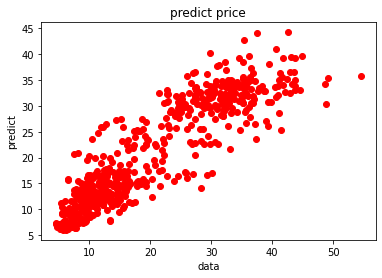

In [42]:
import matplotlib.pyplot as plt
plt.scatter(y_test, pre, c="red")
plt.xlabel("data")
plt.ylabel("predict")
plt.title("predict price")
plt.show()

[Text(279.0, 475.65000000000003, 'Mid_price <= 16.75\nmse = 127.309\nsamples = 3558\nvalue = 16.344'),
 Text(139.5, 339.75, 'Up_price <= 12.65\nmse = 25.058\nsamples = 2127\nvalue = 9.32'),
 Text(69.75, 203.85000000000002, 'Mid_price_min <= 4.75\nmse = 7.431\nsamples = 1211\nvalue = 6.382'),
 Text(34.875, 67.94999999999999, '\n  (...)  \n'),
 Text(104.625, 67.94999999999999, '\n  (...)  \n'),
 Text(209.25, 203.85000000000002, 'Mid_price <= 11.85\nmse = 22.524\nsamples = 916\nvalue = 13.059'),
 Text(174.375, 67.94999999999999, '\n  (...)  \n'),
 Text(244.125, 67.94999999999999, '\n  (...)  \n'),
 Text(418.5, 339.75, 'Mid_price <= 28.25\nmse = 99.208\nsamples = 1431\nvalue = 26.615'),
 Text(348.75, 203.85000000000002, 'Mid_price_max <= 23.75\nmse = 44.817\nsamples = 876\nvalue = 22.08'),
 Text(313.875, 67.94999999999999, '\n  (...)  \n'),
 Text(383.625, 67.94999999999999, '\n  (...)  \n'),
 Text(488.25, 203.85000000000002, 'Avg_price <= 41.8\nmse = 101.922\nsamples = 555\nvalue = 33.692'

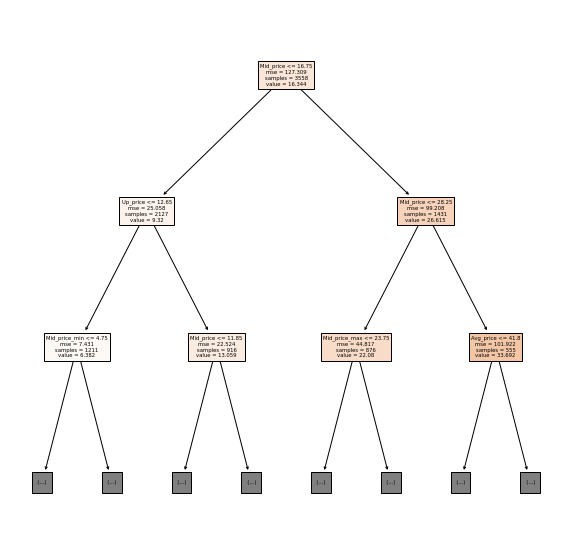

In [43]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
features = new_df.drop(['ans_price'], axis=1).columns
plt.figure(figsize=(10, 10))
plot_tree(clf.estimators_[2], 
          feature_names=features, 
          class_names=['predict_price'],
          max_depth=2,
          filled=True)

In [44]:
result_df = pd.DataFrame({
    "Name":features,
    "Importance":clf.feature_importances_
}).sort_values(by="Importance", ascending=False)
display(result_df[:10])

,Name,Importance
1,Mid_price,0.446142
3,Avg_price,0.255991
0,Up_price,0.094426
81,Mid_price_min,0.015909
7,Month,0.015588
82,Low_price_min,0.007049
67,Mid_price_median,0.006839
74,Mid_price_max,0.005791
69,Avg_price_median,0.005519
9,Year,0.005460


In [45]:
pd.set_option('display.max_row', None)
result_df

,Name,Importance
1,Mid_price,0.446142
3,Avg_price,0.255991
0,Up_price,0.094426
81,Mid_price_min,0.015909
7,Month,0.015588
82,Low_price_min,0.007049
67,Mid_price_median,0.006839
74,Mid_price_max,0.005791
69,Avg_price_median,0.005519
9,Year,0.005460


In [46]:
# # 儲存上面表格的檔案
# result_df.to_csv('/content/drive/MyDrive/AI課程檔案/專題相關/重要性0723(clf0723_ver13).csv')

In [47]:
# 預測跨模型比較的測試集
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
a, b = np.array(test_df.drop(['ans_price'], axis=1)), np.array(test_df['ans_price'])
pre = clf.predict(a)
result_df = pd.DataFrame({
    "data_price":b,
    "predict_price":pre
})
r2 = r2_score(b, pre)
MSE = mean_squared_error(b, pre)
RMSE = np.sqrt(MSE)
print('r2 score:',r2)
print('mse score:',MSE)
print('rmse:', RMSE)
display(result_df.head())

r2 score: 0.7521082957587908
mse score: 26.300169421295507
rmse: 5.1283690800580555


,data_price,predict_price
0,20.2,21.493469
1,17.5,18.187306
2,18.0,17.057661
3,24.9,16.690389
4,25.3,16.171772


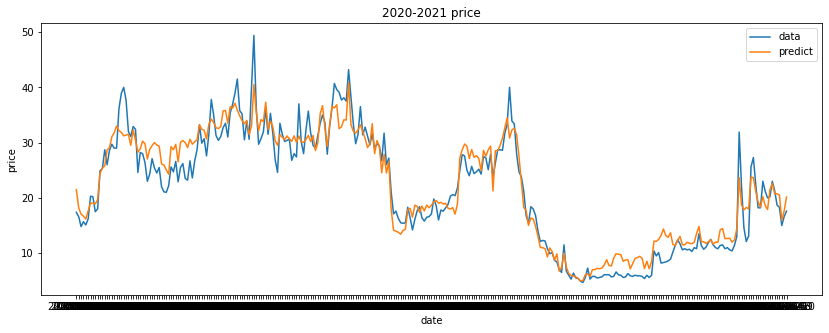

In [48]:
# 把上面的結果畫出來
import matplotlib.pyplot as plt
plt.figure(figsize=(14,5))
plt.plot(test_df.index, test_df.Avg_price, label = "data")
plt.plot(test_df.index, pre, label = "predict")
plt.title("2020-2021 price") # title
plt.ylabel("price") # y label
plt.xlabel("date") # x label
plt.legend() # 圖例的說明
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22825 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20839 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38928 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32080 missing from current font.
  font.set_

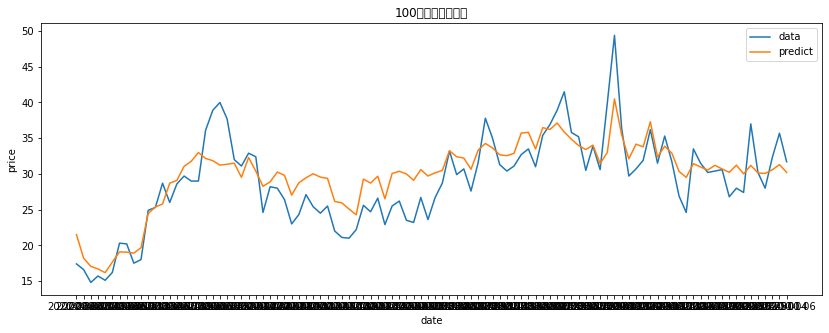

In [49]:
# 把上面的結果畫出來
import matplotlib.pyplot as plt
plt.figure(figsize=(14,5))
plt.plot(test_df.index[:100], test_df.Avg_price[:100], label = "data")
plt.plot(test_df.index[:100], pre[:100], label = "predict")
plt.title("100天內的預測結果") # title
plt.ylabel("price") # y label
plt.xlabel("date") # x label

plt.legend() # 圖例的說明
plt.show()